In [2]:
%matplotlib notebook
import math
import random
import numpy as np
import gym
from parkour_env import parkour_env
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import clear_output

/home/user/.local/lib/python3.9/site-packages/gym/logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


In [3]:
# In order to use the environment as a gym you need to register it with gym
model_name = "DQN"
map_name = "bridge_hole"
res = (96,96)

env = parkour_env(resolution=res, map=map_name, debug=False, fast=True, action_set=4)

/home/user/.local/lib/python3.9/site-packages/minerl/herobraine/hero/spaces.py:484: UserWarning: The Text MineRLSpace class is not fully implemented. This may cause problems when sampling an action of this type (even when getting a noop).
  warnings.warn("The Text MineRLSpace class is not fully implemented. This may cause problems when sampling an action of this type (even when getting a noop).")


In [4]:
sample_state = env.observation_space.sample()
sample_action = env.action_space.sample()
image_shape = sample_state['pov'].shape

In [5]:
# this line might take a couple minutes to run
# obs = env.reset()

In [7]:
print("Sample action:", sample_action)
print("Sample pov space", image_shape)
print("n actions", env.n_actions)
# env.observation_space.sample()['location_stats']['ypos']>10

Sample action: 3
Sample pov space (96, 96, 3)
n actions 5


# Build DQN Agent
https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

In [8]:
from collections import namedtuple, deque
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Replay Memory

We’ll be using experience replay memory for training our DQN. It stores the transitions that the agent observes, allowing us to reuse this data later. By sampling from it randomly, the transitions that build up a batch are decorrelated. It has been shown that this greatly stabilizes and improves the DQN training procedure.

For this, we’re going to need two classses:
- `Transition` - a named tuple representing a single transition in our environment. It essentially maps (state, action) pairs to their (next_state, reward) result, with the state being the screen difference image as described later on.
- `ReplayMemory` - a cyclic buffer of bounded size that holds the transitions observed recently. It also implements a .sample() method for selecting a random batch of transitions for training.

In [9]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

## Q-network
Our model will be a convolutional neural network that takes in the current and previous screen patches. It has 4 outputs, representing (cameraX_-30deg, cameraX_+30deg, front, jump)

In [10]:
class DQN(nn.Module):
    def __init__(self, h, w, outputs):
        super(DQN, self).__init__()
        # The number of input channel is:  "# of stacked image" * 3
        # TODO:
        # 1. change resolution from 96*96 to 64*64 (also fix the linear layer)
        # 2. remove BatchNorm
        # 3. Add maxpooling
        self.conv1 = nn.Conv2d(12, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 48, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(48)

        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 32
        self.dense1 = nn.Linear(3888, 1024)
        self.head = nn.Linear(1024, outputs)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        #print(x.shape)
        x = x.to(device)
        x = F.sigmoid(self.bn1(self.conv1(x)))
        x = F.sigmoid(self.bn2(self.conv2(x)))
        x = F.sigmoid(self.bn3(self.conv3(x)))
        x = torch.flatten(x, start_dim=1)
        x = F.sigmoid(self.dense1(x))
        x = self.head(x)
        return x
class queue():
    def __init__(self, n_stacked_img, dim, stride=1):
        self.data = []
        self.stride = stride
        self.size = (n_stacked_img - 1) * stride + 1
        for i in range(self.size):
            self.data.append(torch.zeros(dim))
    def push(self, img):
        self.data[:-1] = self.data[1:]
        self.data[-1] = img
    def get(self):
        return torch.cat(self.data[::self.stride]).unsqueeze(0).to(device)
    def fill(self, img):
        for i in range(self.size):
            self.data[i] = img

In [11]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the AdamW optimizer
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.10
EPS_DECAY = 10000
TAU = 0.005
LR = 1e-4

n_actions = env.n_actions
h = res[0]
w = res[1]
policy_net = DQN(h, w, n_actions).to(device)
target_net = DQN(h, w, n_actions).to(device)
# target_net.load_state_dict(torch.load("policy_net.torch"))
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)

steps_done = 0

def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            #state = torch.permute(state, (2,0,1))
            # state = torch.unsqueeze(state, dim=0)
            # return torch.argmax(policy_net(state), dim=1).squeeze()
            x = policy_net(state)
            x = torch.nn.functional.softmax(x, dim=1)
            m = torch.distributions.Categorical(x)
            re = m.sample().cpu().numpy()[0]
            return torch.tensor([[re]], device=device, dtype=torch.long)
    else:
        return torch.tensor([[random.randint(0, n_actions-1)]], device=device, dtype=torch.long)

episode_durations = []

def plot_durations():
    plt.figure(1)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        display.clear_output(wait=True)
        display.display(plt.gcf())


RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [ ]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)


    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()
def convert_state(state):
    x = torch.tensor(state['pov'].copy(), dtype=torch.float32)
    x = torch.permute(x, (2,0,1))
    return x/255
total_episodes = 0
rewards = []

<IPython.core.display.Javascript object>


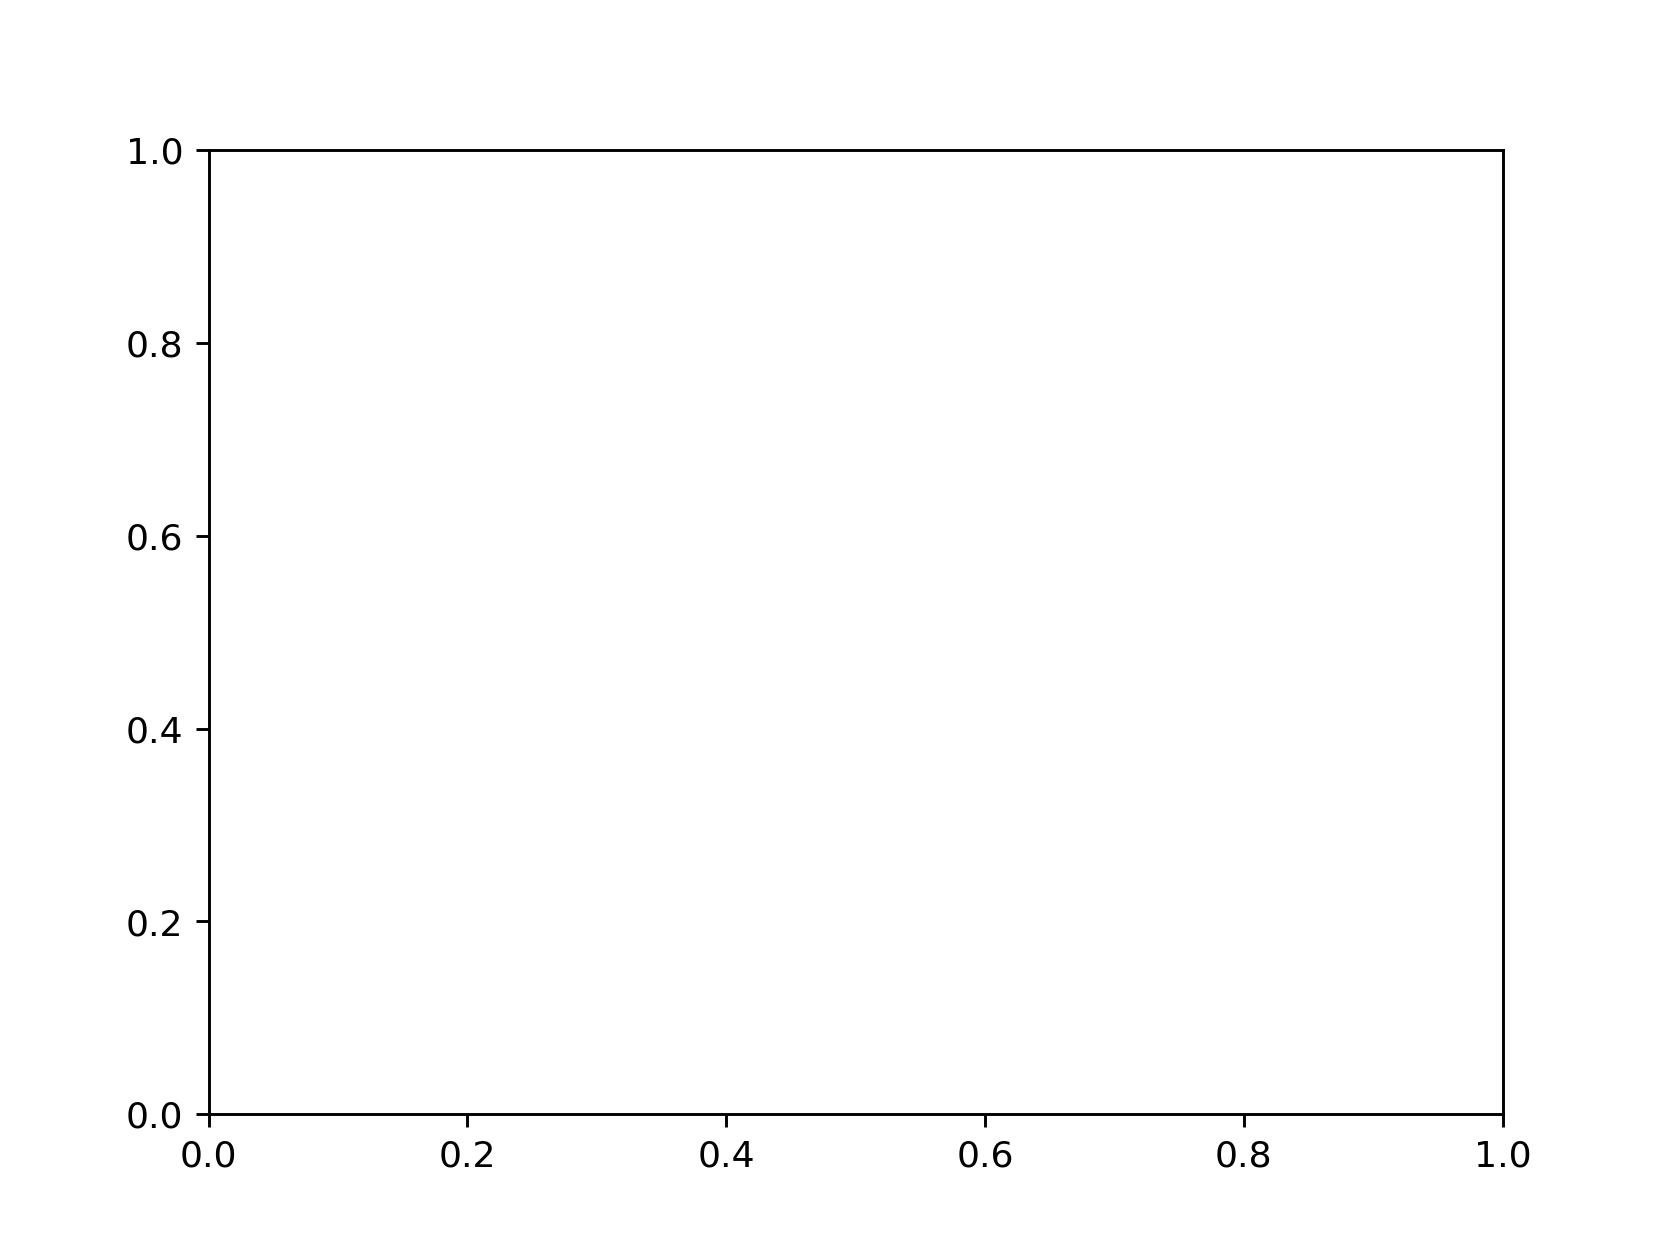

Resetting environment.


/home/user/.local/lib/python3.9/site-packages/minerl/herobraine/hero/spaces.py:484: UserWarning: The Text MineRLSpace class is not fully implemented. This may cause problems when sampling an action of this type (even when getting a noop).
  warnings.warn("The Text MineRLSpace class is not fully implemented. This may cause problems when sampling an action of this type (even when getting a noop).")
/home/user/.local/lib/python3.9/site-packages/gym/logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))
/opt/conda/lib/python3.9/runpy.py:127: RuntimeWarning: 'minerl.utils.process_watcher' found in sys.modules after import of package 'minerl.utils', but prior to execution of 'minerl.utils.process_watcher'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))


NameError: name 'convert_state' is not defined

In [12]:
num_episodes = 1000
plt.ion()
# Create a plot
fig, ax = plt.subplots(1,1)

que = queue(n_stacked_img=4, dim=(3, res[0], res[1]), stride=3)
for i_episode in range(num_episodes):
    state = env.reset()
    state = convert_state(state)
    que.fill(state)
#     print(que.get().shape)
#     print(i_episode, EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY))
    last_dis = 0
    total_reward = 0
    for t in count():
        env.render()
        history_state = que.get()
        action = select_action(history_state)
        #print(action)
        actionInt = int(action)
        
        observation, reward, done, info = env.step(actionInt)
        total_reward += reward
        if t % 10 == 0:
            ax.clear()
            ax.set_title(f'episode: {total_episodes} step: {t} reward: {reward:.2f}')
            ax.imshow(observation['pov'])
            fig.canvas.draw()

        if (reward >= 50):
            print(reward, done)
            done = True
        r = reward
        reward = torch.tensor([reward], device=device, dtype=torch.float)
#         print(reward)
        if done:
            next_state = None
        else:
            next_state = convert_state(observation)
            que.push(next_state)
        # Store the transition in memory
        memory.push(history_state, action, que.get(), reward)
        # Move to the next state
        # state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()
        
        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            total_episodes += 1
            episode_durations.append(t + 1)
            rewards.append(r)
            #plot_durations()
            break
    

In [ ]:
from matplotlib.pyplot import figure
from brokenaxes import brokenaxes
bax = brokenaxes(ylims=((-60, -40), (50, 109)),
                hspace=0.25,diag_color='r')

bax.scatter(np.linspace(0, len(rewards)-1, len(rewards)), rewards, s=5)

bax.set_xlabel("episodes")
bax.set_ylabel("reward")
bax.set_title(f"Training history")
plt.show()

In [ ]:
#env.close()
# torch.save(policy_net.state_dict(), f"{model_name}_{map_name}_{res[0]}x{res[1]}.torch")

In [ ]:
# env.render()
# action = env.action_space.noop()
# #action['camera'][1] = +30
# action['jump'] = 1
# obs, reward, done, info = env.step(action)

In [ ]:
#obs = env.reset()

In [ ]:
# env.close()